In [1]:
import emcee
import corner
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from uncertainties import ufloat
from uncertainties.umath import *
from uncertainties import unumpy as unp
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
cosmo=FlatLambdaCDM(70, 0.3)
from statistics_functions import chi_squared

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
data = pd.read_csv('data/reflex70.txt', header=7, sep='|', skiprows=[range(6), 8],on_bad_lines='warn', skipfooter=1, skipinitialspace=True).rename(columns=lambda x: x.strip())
#data = data.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)
#data['Name'].values.strip()
data = data.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)
#data['Name']

mcxccls=pd.read_csv('data/mcxc|.txt', header=3, sep='|', skiprows=[4],on_bad_lines='warn', skipfooter=1).rename(columns=lambda x: x.strip())
mcxccls = mcxccls.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)
mcxc_data = mcxccls[mcxccls['Sub-Cat']=='REFLEX'][['AName', 'L500']].rename(columns={'AName': 'Name'})
#mcxc_data

L500s=[]
ObsLum_mcxc=[]
for name in mcxc_data['Name']:
    L500s.append(mcxc_data[mcxc_data['Name']==name]['L500'].values[0])
    ObsLum_mcxc.append(data[data['Name']==name]['ObsLum'].values)
    
mcxc_data_clean=mcxc_data.dropna()
data_clean=data[['Name', 'Flux', 'e_Flux', 'ObsLum', 'LumCor', 'z']].dropna()

comb = pd.merge(mcxc_data_clean, data_clean, on='Name', how='inner', sort=True)
comb

/var/folders/99/vfh56jrs1nqcj8zqtcs5fkv40000gn/T/ipykernel_39701/2159843122.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  data = pd.read_csv('data/reflex70.txt', header=7, sep='|', skiprows=[range(6), 8],on_bad_lines='warn', skipfooter=1, skipinitialspace=True).rename(columns=lambda x: x.strip())
/var/folders/99/vfh56jrs1nqcj8zqtcs5fkv40000gn/T/ipykernel_39701/2159843122.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  mcxccls=pd.read_csv('data/mcxc|.txt', header=3, sep='|', skiprows=[4],on_bad_lines='warn', skipfooter=1).rename(columns=lambda x: x.strip())


,Name,L500,Flux,e_Flux,ObsLum,LumCor,z
0,1ES0657,20.425901,9.079,7.9,21.646,23.028,0.2965
1,A0013,1.236332,6.071,11.3,1.285,1.353,0.0940
2,A0022,2.872451,5.910,12.1,2.909,3.232,0.1410
3,A0042,1.404549,4.836,13.3,1.491,1.521,0.1120
4,A0085,5.100085,74.215,3.2,5.293,5.631,0.0555
...,...,...,...,...,...,...,...
330,S1101,1.811143,23.412,7.2,1.738,1.998,0.0564
331,S1136,0.504007,5.273,20.5,0.516,0.549,0.0643
332,USGC S152,0.073319,10.929,6.8,0.059,0.072,0.0155
333,Zw0258.9,3.711221,4.973,15.8,3.704,4.209,0.1712


In [3]:
d_L = cosmo.comoving_distance(comb['z']).to(u.m).value #(return meters)
#flux_var=ufloat(comb['Flux'].to_numpy(), comb['e_Flux'].to_numpy())
#Lobs_calc=(comb['Flux'].to_numpy()*u.W*1e-15/u.m**2 * 4*np.pi * d_L**2).to(u.W)
flux_arr=comb['Flux'].to_numpy()*1e-15 # to get in watts
eflux_arr=comb['e_Flux'].to_numpy()
flux_var=np.array([ufloat(flux_arr[i],eflux_arr[i]*flux_arr[i]/100) for i in range(len(flux_arr))])

#originally in units u.W*1e-15/u.m**2 * Mpc**2
Lobs_calc=(flux_var*4*np.pi*d_L**2) * 1e-37 

#Lobs_calc #now in units of 1e37 W
Lobs_err = [L.std_dev for L in Lobs_calc]
#Lobs_err
Lobs_calc

array([15.16477333094314+/-1.1980170931445084,
       1.1271051139128871+/-0.12736287787215625,
       2.4135326772236376+/-0.2920374539440601,
       1.2636774736720755+/-0.16806910399838607,
       4.890977692536981+/-0.1565112861611834,
       1.4123668858975584+/-0.0748554449525706,
       1.3174099397720227+/-0.08826646596472552,
       4.038331052992539+/-0.6340179753198285,
       2.3439580301644063+/-0.49457514436468974,
       0.17867807055659995+/-0.028588491289055995,
       0.4175108555327666+/-0.04091606384221112,
       0.7310138525491998+/-0.11184511944002756,
       0.45404892283675474+/-0.042226549823818196,
       0.06850405314420975+/-0.009659071493333575,
       4.626941855990165+/-0.48120195302297714,
       1.125017897474621+/-0.16537763092876928,
       3.2595224943566943+/-0.37484508685101986,
       0.14072231260275045+/-0.019278956826576807,
       1.4289856888365742+/-0.2557884383017467,
       0.5944896391994711+/-0.0867954873231228,
       2.987278963518106

In [4]:
# MCMC: L_o=(L_c - b)/m 
# change to L_o=(L500-b)/m
L_obs_data = comb['ObsLum']
L_obs_var=[L.std_dev for L in Lobs_calc]
#L_cor=comb['LumCor']
L500=comb['L500']

Text(0, 0.5, 'L500')

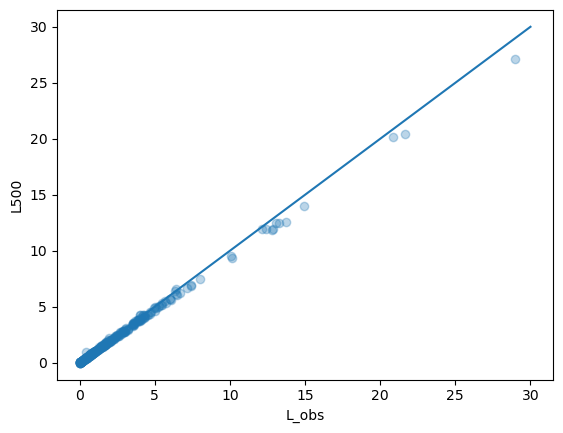

In [5]:
plt.scatter(L_obs_data, L500, alpha=0.3)
plt.plot(np.linspace(0,30), np.linspace(0,30))
plt.xlabel('L_obs')
plt.ylabel('L500')

In [12]:
def log_lik(p0, L_c, obs, var):
    m=p0[0]
    if np.abs(m)<0.00001:
        return -np.inf
    b=p0[1]
    if np.abs(m)>10 or np.abs(b)>10:
        return -np.inf
    pred=(L_c-b)/m
    return -1*chi_squared(pred, obs, var)/2

In [15]:
p0=[1, 0]
log_lik(p0, L500, L_obs_data, L_obs_var)

-1560.2634323644402

In [16]:
ndim=2
nwalkers = 32
guess=(1, 0)
p0 = guess+np.random.normal(scale=0.1, size=(nwalkers, ndim))
p0

array([[ 1.07716884,  0.01485539],
       [ 1.00423735,  0.11712741],
       [ 0.92859159,  0.18390263],
       [ 1.21637052, -0.08350977],
       [ 0.84404833, -0.13991141],
       [ 1.03795249, -0.1835738 ],
       [ 0.85525362,  0.05668858],
       [ 0.88842663,  0.04667623],
       [ 1.17324653,  0.11729177],
       [ 1.0088333 , -0.02472528],
       [ 1.10438269,  0.0490322 ],
       [ 1.13677639, -0.07441421],
       [ 1.00286547,  0.04083198],
       [ 0.83520687, -0.01113863],
       [ 0.97905843,  0.12604382],
       [ 1.11285852, -0.02453342],
       [ 1.01921483,  0.02314186],
       [ 1.01824389,  0.08992648],
       [ 0.98269581,  0.10325314],
       [ 1.07615003, -0.09849415],
       [ 0.8683118 , -0.0656289 ],
       [ 0.90168014, -0.14033394],
       [ 0.94077944,  0.03130053],
       [ 0.96759406,  0.06370836],
       [ 0.94530797,  0.01116698],
       [ 1.24420513,  0.09774292],
       [ 0.83984603, -0.06126602],
       [ 1.17796373,  0.06285808],
       [ 1.02137149,

In [17]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_lik, args=[L500, L_obs_data, L_obs_var])

In [18]:
state = sampler.run_mcmc(p0, 100, progress=True)
sampler.reset()

100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 19.68it/s]


In [19]:
sampler.run_mcmc(state, 5000, progress=True)

100%|███████████████████████████████████████| 5000/5000 [04:17<00:00, 19.44it/s]


State([[1.04169853 0.00364139]
 [1.04896845 0.0038362 ]
 [1.04567978 0.00389228]
 [1.04844702 0.00396532]
 [1.0419099  0.00388205]
 [1.05085045 0.00399763]
 [1.05070399 0.00382519]
 [1.04977595 0.00384707]
 [1.04816507 0.0037934 ]
 [1.04349705 0.00407059]
 [1.04229949 0.0039255 ]
 [1.04219638 0.0042114 ]
 [1.04640825 0.00410435]
 [1.05507252 0.00367234]
 [1.06107142 0.00394845]
 [1.04418923 0.00373231]
 [1.04660966 0.00386452]
 [1.04539357 0.00407132]
 [1.04631642 0.00411135]
 [1.05391719 0.00372917]
 [1.0542949  0.00410449]
 [1.04763154 0.00384009]
 [1.04623775 0.00394348]
 [1.04605899 0.00392694]
 [1.05413805 0.00381867]
 [1.05060394 0.00368458]
 [1.03744127 0.003948  ]
 [1.05268446 0.00378783]
 [1.04754034 0.00408581]
 [1.04416728 0.00401172]
 [1.05248277 0.00385384]
 [1.04552493 0.00359919]], log_prob=[-1175.16688109 -1173.00701186 -1173.11089728 -1173.10419138
 -1173.80406412 -1173.38696474 -1173.11176604 -1173.02040219
 -1173.11065226 -1173.98235349 -1173.70477466 -1175.47951063


In [20]:
flat_samples = sampler.get_chain(flat=True)
print(flat_samples.shape)

(160000, 2)


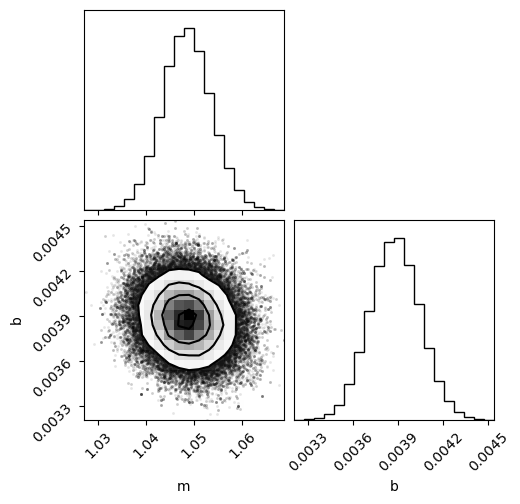

In [21]:
fig = corner.corner(flat_samples, labels=['m', 'b']) 

In [22]:
sampler.get_chain()

array([[[1.05192542, 0.00391765],
        [1.04238142, 0.00410923],
        [1.04575923, 0.00393142],
        ...,
        [1.05252196, 0.00387958],
        [1.04857378, 0.00374588],
        [1.04205807, 0.00421971]],

       [[1.05192542, 0.00391765],
        [1.04270271, 0.00405998],
        [1.04548477, 0.00394195],
        ...,
        [1.05297858, 0.00385044],
        [1.0498495 , 0.00369682],
        [1.04222094, 0.00421416]],

       [[1.05192542, 0.00391765],
        [1.04270271, 0.00405998],
        [1.04754989, 0.00390786],
        ...,
        [1.05297858, 0.00385044],
        [1.04781397, 0.00376926],
        [1.04188491, 0.00421113]],

       ...,

       [[1.04169853, 0.00364139],
        [1.04805532, 0.00383726],
        [1.04807509, 0.00373334],
        ...,
        [1.04563553, 0.00395683],
        [1.05143517, 0.00384727],
        [1.04495589, 0.00377209]],

       [[1.04169853, 0.00364139],
        [1.04896845, 0.0038362 ],
        [1.04652402, 0.00391456],
        .

In [23]:
tau = sampler.get_autocorr_time()
print(tau)

[32.07255934 33.7543247 ]


In [24]:
np.median(flat_samples[:,0]), np.median(flat_samples[:,1])

(1.0484334971276335, 0.0038766842502834273)

In [25]:
m_err=np.var(flat_samples[:,0]) # var=mean((p-pmean)**2)
m_err

2.5619772376197376e-05

In [26]:
b_err=np.var(flat_samples[:,1])
b_err

2.7776019050456584e-08

In [27]:
m_uf=ufloat(np.median(flat_samples[:,0]), np.var(flat_samples[:,0]))
b_uf=ufloat(np.median(flat_samples[:,1]), np.var(flat_samples[:,1]))

m_uf, b_uf # uncertainty too small??

(1.0484334971276335+/-2.5619772376197376e-05,
 0.0038766842502834273+/-2.7776019050456584e-08)

In [28]:
L_obs_uf=unp.uarray(comb['ObsLum'], [L.std_dev for L in Lobs_calc])

L500_pred=m_uf*L_obs_uf+b_uf

In [30]:
L500_uf=unp.uarray(comb['L500'], [L.std_dev for L in L500_pred])
L500_uf

array([20.425901+/-1.256041373009689, 1.236332+/-0.13353151151003695,
       2.872451+/-0.30618185820126614, 1.404549+/-0.1762092826045833,
       5.100085+/-0.16409173112211936, 1.437223+/-0.07848096540240176,
       1.460216+/-0.09254152693403889, 5.160525+/-0.6647256975885781,
       2.779734+/-0.5185291539329757, 0.192363+/-0.02997313230343764,
       0.491051+/-0.04289777349359554, 0.815085+/-0.11726217170953983,
       0.467516+/-0.04427173106879033, 0.069782+/-0.010126894263595932,
       5.701343+/-0.504508270140511, 1.286803+/-0.1733874514165482,
       4.271815+/-0.39300016001211563, 0.147336+/-0.020212704496891255,
       1.768408+/-0.26817717076219266, 0.669697+/-0.09099929797181426,
       3.823944+/-0.4823223636446193, 4.123734+/-0.6603859424946377,
       3.027404+/-0.3846097717477051, 1.462214+/-0.1348550926758947,
       1.85299+/-0.06425111572099715, 1.947777+/-0.9993634734176895,
       0.65502+/-0.09945933399064577, 1.004022+/-0.08715520928751591,
       7.44515+/-1

In [ ]:
#do this again but just go straight from Lobs to L500